In [1]:
"""
Name: example_prob_model_application.ipynb
Authors: Stephan Meighen-Berger
Example how to apply the probabilistic model
TODO: Implement this in the main code
"""

'\nName: example_prob_model_application.ipynb\nAuthors: Stephan Meighen-Berger\nExample how to apply the probabilistic model\nTODO: Implement this in the main code\n'

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
from tqdm import tqdm
import pickle
from scipy.interpolate import RectBivariateSpline, UnivariateSpline
# from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
from fourth_day.pdfs import construct_pdf

In [5]:
# picture path
PICS = '../pics/'

In [6]:
# Plotting standards
std_size = 6.
fontsize = 20.
lw=1.
h_length=1.

In [7]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [8]:
data_0 = pickle.load( open("offcenter_0.p", "rb" ) )
data_1 = pickle.load( open("offcenter_1.p", "rb" ) )
data_2 = pickle.load( open("offcenter_2.p", "rb" ) )
data_3 = pickle.load( open("offcenter_3.p", "rb" ) )

In [9]:
id_alpha = 0
counts_0, edges_0 = np.histogram(
    data_0['x_arr'][id_alpha],
    bins=np.linspace(0., 26., 131),
    weights=1./data_0['norm'][id_alpha]
)
counts_1, edges_1 = np.histogram(
    data_1['x_arr'][id_alpha],
    bins=np.linspace(0., 26., 131),
    weights=1./data_1['norm'][id_alpha]
)
counts_2, edges_2 = np.histogram(
    data_2['x_arr'][id_alpha],
    bins=np.linspace(0., 26., 131),
    weights=1./data_2['norm'][id_alpha]
)
counts_3, edges_3 = np.histogram(
    data_3['x_arr'][id_alpha],
    bins=np.linspace(0., 26., 131),
    weights=1./data_3['norm'][id_alpha]
)

In [10]:
spl_prob = RectBivariateSpline(
    (edges_0[1:] + edges_0[:-1]) / 2.,
    np.array([0., 1., 2., 3.]),
    np.array([counts_0, counts_1, counts_2, counts_3]).T, s=0.4)

In [11]:
dx2, dy2 = 0.1, 0.1
x2 = np.arange(0., 3., dx2)
y2 = np.arange(0., 26., dy2)
X2, Y2 = np.meshgrid(x2,y2)
Z2 = spl_prob(y2, x2)
Z2[Z2 < 0.] = 0.

In [12]:
# %matplotlib notebook
# figure, ax = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True, subplot_kw={'projection': '3d'})
# ax.plot_wireframe(X2, Y2, Z2, color='k')

In [13]:
# Parameters
detector_position = np.array([0., 0.])
dens = 1e-1
acceptance_range = np.array([30., 90.])
simulation_step = 0.1
simulation_time = 1000.
wavelengths = np.linspace(300., 600., 301)
emission_time = 100.
photon_counts = 1e10
efficiency = 0.1
water_vel = 0.5 * simulation_step
rest_time = 100. / simulation_step
species = np.array(["Species 1", "Species 2"])
gamma_test = construct_pdf(
    {"class": "Gamma",
     "mean": 2. / simulation_step,
     "sd": 1.5 / simulation_step
    })
gamma_test_2 = construct_pdf(
    {"class": "Gamma",
     "mean": 0.2 / simulation_step,
     "sd": 0.15 / simulation_step
    })
gauss_test = construct_pdf(
    {"class": "Normal",
     "mean": 450.,
     "sd": 50.
    })
min_y = 0.
max_y = 3.
max_x = 26.
starting_pop = 2
pop_size = starting_pop
injection_count = dens * (max_y - min_y) * water_vel
expected_counts = int(injection_count * simulation_time)
injection_times = np.sort(np.random.randint(int(simulation_time / simulation_step), size=expected_counts))

In [14]:
unqiue_times, unique_counts = np.unique(injection_times, return_counts=True)

In [15]:
# The population
population = pd.DataFrame(
    {
        "species": None,
        "pos_x": 0.,
        "pos_y": 0.,
        "observed": True,
        "flashing": False,
        "can_flash": True,
        "rest_time": 0,
    },
    index=np.arange(starting_pop),
)
population.loc[:, 'pos_y'] = np.random.uniform(min_y, max_y, starting_pop)
# Species
if len(species) > 1:
    pop_index_sample = np.random.randint(
        0, len(species), starting_pop
    )
elif len(species) == 1:
    pop_index_sample = np.zeros(starting_pop, dtype=np.int)
population.loc[:, 'species'] = (
    species[pop_index_sample]
)

In [16]:
statistics = list(range(int(simulation_time / simulation_step)))
for i in tqdm(range(int(simulation_time / simulation_step))):
    counter = 0
    # Resetting the flash
    population.loc[:, 'flashing'] = False
    if i in unqiue_times:
        inject = unique_counts[counter]
        for j in range(inject):
            if len(species) > 1:
                pop_index_sample = np.random.randint(
                    0, len(species), 1
                )
            elif len(species) == 1:
                pop_index_sample = np.zeros(1, dtype=np.int)
            population.loc[pop_size + (j+1)] = [
                species[pop_index_sample][0],
                0.,
                np.random.uniform(min_y, max_y),
                True,
                False,
                True,
                0
            ]
            pop_size += 1
        counter += 1
    # Injection only according to array
    observation_mask = population.loc[:, 'observed']
    # propagation
    population.loc[observation_mask, 'pos_x'] = population.loc[observation_mask, 'pos_x'] + water_vel
    # Checking if should emit
    prob_arr = spl_prob(
        population.loc[observation_mask, 'pos_x'].values,
        population.loc[observation_mask, 'pos_y'].values, grid=False)
    prob_arr[prob_arr < 0.] = 0.
    flash_mask = np.logical_and(np.array(np.random.binomial(1, prob_arr, len(prob_arr)), dtype=bool),
                                population.loc[observation_mask, 'can_flash'].values)
    population.loc[observation_mask, 'flashing'] += flash_mask
    can_flash_mask =  population.loc[:, 'flashing'].values
    population.loc[can_flash_mask, 'can_flash'] = False
    # Counting the rest
    resting_mask = population.loc[:, 'can_flash'].values
    population.loc[~resting_mask, 'rest_time'] += 1
    # Checking if can flash again
    flash_mask = np.greater(population.loc[:, 'rest_time'], rest_time)
    population.loc[flash_mask, 'rest_time'] = 0
    population.loc[flash_mask, 'can_flash'] = True
    # Observed
    new_observation_mask = np.less(population.loc[observation_mask, 'pos_x'], max_x)
    population.loc[observation_mask, 'observed'] = new_observation_mask
    statistics[i] = population.copy()

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]C:\Users\steph\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:46<00:00, 93.94it/s]


In [17]:
flashes = np.zeros(len(statistics))
for id_pop, pop in enumerate(statistics):
    flashes[id_pop] = (np.sum(pop.loc[:, "flashing"]))

In [18]:
x_arr = np.arange(len(flashes))

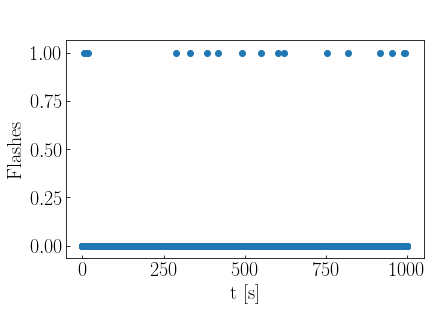

In [19]:
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
ax1.scatter(x_arr * simulation_step, flashes)
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlabel(r'$\mathrm{t}\;[\mathrm{s}]$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{Flashes}$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.5, +1.2),
                  ncol=5, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
# ax1.set_ylim(1e3,1e7)
# ax1.set_xlim(350, 400)
plt.tight_layout()
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


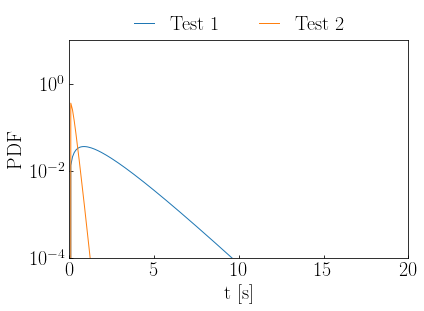

In [20]:
# Testing the time pdf
test_grid = np.linspace(0., 100. / simulation_step, 1000)
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
ax1.plot(test_grid * simulation_step,
         gamma_test.pdf(test_grid),
         lw=lw, label=r'$\mathrm{Test\;1}$')
ax1.plot(test_grid * simulation_step,
         gamma_test_2.pdf(test_grid),
         lw=lw, label=r'$\mathrm{Test\;2}$')
ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r'$\mathrm{t}\;[\mathrm{s}]$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{PDF}$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.5, +1.2),
                  ncol=5, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.set_ylim(1e-4, 1e1)
ax1.set_xlim(0., 20)
plt.tight_layout()
plt.show()

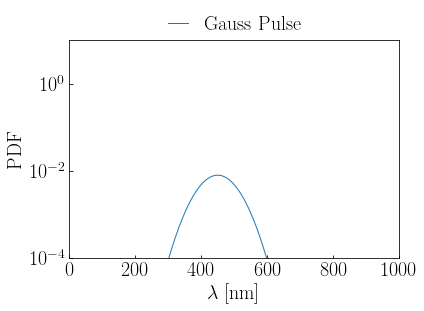

In [21]:
# Testing the gaus pdf
test_grid = np.linspace(0., 1000., 1000)
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
ax1.plot(test_grid,
         gauss_test.pdf(test_grid),
         lw=lw, label=r'$\mathrm{Gauss\; Pulse}$')
ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r'$\lambda\;[\mathrm{nm}]$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{PDF}$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.5, +1.2),
                  ncol=5, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.set_ylim(1e-4, 1e1)
ax1.set_xlim(0., 1000)
plt.tight_layout()
plt.show()

In [22]:
# Normalizing pdfs
norm_time_series_1 = (
    gamma_test.pdf(np.arange(0., emission_time, simulation_step)) /
    np.trapz(gamma_test.pdf(np.arange(0., emission_time, simulation_step)),
             np.arange(0., emission_time, simulation_step))
)
norm_time_series_2 = (
    gamma_test_2.pdf(np.arange(0., emission_time, simulation_step)) /
    np.trapz(gamma_test.pdf(np.arange(0., emission_time, simulation_step)),
             np.arange(0., emission_time, simulation_step))
)
norm_time_series_1 = norm_time_series_1 * photon_counts
norm_time_series_2 = norm_time_series_2 * photon_counts
norm_dic = {
    species[0]: norm_time_series_1,
    species[1]: norm_time_series_2
}
norm_wavelengths = (
    gauss_test.pdf(wavelengths) /
    np.trapz(gauss_test.pdf(wavelengths), wavelengths)
)

In [23]:
# The attenuation function
attenuation_vals = np.array([
    [
        299.,
        329.14438502673795, 344.11764705882354, 362.2994652406417,
        399.44415494181, 412.07970421102266, 425.75250006203635,
        442.53703565845314, 457.1974490682151, 471.8380108687561,
        484.3544504826423, 495.7939402962853, 509.29799746891985,
        519.6903148961513, 530.0627807141617, 541.5022705278046,
        553.9690811186382, 567.4929899004939, 580.9771954639073,
        587.1609717362714, 593.3348222040249, 599.4391920395047,
        602.4715253480235
    ],
    [
        0.8,
        0.6279453220864465,0.3145701363176568,
        0.12591648888305143,0.026410321551339357, 0.023168667048510762,
        0.020703255370450736, 0.019552708373076478,
        0.019526153330089138, 0.020236306473695613,
        0.02217620815962483, 0.025694647290888873,
        0.031468126242251794, 0.03646434475343956,
        0.04385011375530569, 0.05080729755501162,
        0.061086337538657706, 0.07208875589035815, 0.09162216168767365,
        0.11022281058708046, 0.1350811713674855, 0.18848851206491904,
        0.23106528395398912
    ]
])
atten_spl = UnivariateSpline(attenuation_vals[0], attenuation_vals[1], k=1, s=0)
atten_vals = atten_spl(wavelengths)

In [24]:
# Applying emission pdf
# And propagating
arriving_light = np.zeros((int(simulation_time / simulation_step), len(wavelengths)))
for id_step, pop in enumerate(statistics):
    flashing_mask = pop.loc[:, 'flashing'].values
    if np.sum(flashing_mask) > 0:
        x_arr = pop.loc[flashing_mask, 'pos_x'].values
        y_arr = pop.loc[flashing_mask, 'pos_y'].values
        species_arr = pop.loc[flashing_mask, "species"].values
        distances = np.sqrt(
            (x_arr - detector_position[0])**2. +
            (y_arr - detector_position[1])**2.
        )
        angles = np.array(
            np.arctan2(
                (y_arr - detector_position[1]),
                (x_arr - detector_position[0]))
        )
        angles = np.degrees(angles)
        outside_minus = np.less(angles, acceptance_range[0])
        outside_plus = np.greater(angles, acceptance_range[1])
        angle_check = np.logical_and(~outside_minus, ~outside_plus)
        angle_squash = angle_check.astype(float)
        atten_facs = np.array([
            np.exp(-distances[id_flash] * atten_vals) / (4. * np.pi * distances[id_flash]**2.)
            for id_flash in range(np.sum(flashing_mask))
        ])
        curr_pulse = np.array([
            [
                (norm_time * norm_wavelengths * atten_facs[id_flash]) * efficiency * angle_squash[id_flash]
                for norm_time in norm_dic[species_arr[id_flash]]
            ]
            for id_flash in range(np.sum(flashing_mask))
        ])
        # Checking if end is being overshot
        if id_step+int(emission_time / simulation_step) <= len(arriving_light):
            arriving_light[id_step:id_step+int(emission_time / simulation_step), :] += (
                np.sum(curr_pulse, axis=0)
            )
        else:
            arriving_light[id_step:id_step+int(emission_time / simulation_step), :] += (
                np.sum(curr_pulse, axis=0)[0:len(arriving_light) - (id_step+int(emission_time / simulation_step))]
            )

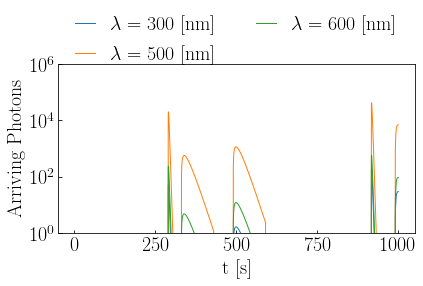

In [26]:
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
id_1 = 0
id_2 = 200
id_3 = 300
ax1.plot(np.arange(0., simulation_time, simulation_step), arriving_light[:, id_1],
         lw=lw, label=r'$\lambda = %.f\;\mathrm{[nm]}$' % wavelengths[id_1])
ax1.plot(np.arange(0., simulation_time, simulation_step), arriving_light[:, id_2],
         lw=lw, label=r'$\lambda = %.f\;\mathrm{[nm]}$' % wavelengths[id_2])
ax1.plot(np.arange(0., simulation_time, simulation_step), arriving_light[:, id_3],
         lw=lw, label=r'$\lambda = %.f\;\mathrm{[nm]}$' % wavelengths[id_3])
ax1.set_xscale('linear')
ax1.set_yscale('log')
ax1.set_xlabel(r'$\mathrm{t}\;[\mathrm{s}]$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{Arriving\;Photons}$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.5, +1.4),
                  ncol=2, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.set_ylim(1e0, 1e6)
# ax1.set_xlim(0., 20)
plt.tight_layout()
plt.show()
figure.savefig(PICS + "Prob_Zoom.png",
               bbox_inches='tight')